# Multi Class LSTM and Random Forest:
Implements a multi-class LSTM and Random Forest. Trains a LSTM and Random Forest. The code preprocesses a dataset for for all labels based on a correlation threshold (only applied to categorical features currently). Then it trains a LSTM and Random Forest and prints the evaluations for each label. Has options for a downsampled dataset and the full dataset.

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import random
import shap
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [18]:
def plot_metrics(train, val, epochs, title):
    """
    Plot the training, validation, and test metrics.

    Parameters:
        - train_loss (list): Training metric.
        - val_loss (list): Validation metric.
        - test_loss (list): Test tmetric.
        - epochs (int): The number of epochs.
        - title (string): The title of the plot.
    """

    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epochs + 1), train, label='Training', color=sns.color_palette("pastel")[0])
    plt.plot(range(1, epochs + 1), val, label='Validation', color=sns.color_palette("pastel")[1])
    plt.xlabel('Epochs')
    plt.ylabel(f"{title}")
    plt.title(f"{title}")
    plt.legend()
    plt.ylim(bottom=0)
    plt.show()

In [ ]:
import pandas as pd

class CorrEncoder:
    """
    CorrEncoder: Takes a dataset as input and uses it for the encode function. Encodes the filtered categories then draws correlations.
    If correlation is above the threshold adds it to a new dataframe then returns the one hot encoded values with the labels.

    Initialisation:
        - data (pd.DataFrame): The Dataset that contains the target column and target label variables.
    """
    
    def __init__(self, data):
        self.data = data.copy()
        # Removes Label for the multi-class processing as it is based on the label category (threat or not).
        self.data = self.data.drop(columns=['attack_cat'])

    def encode(self, target_column, sparse_n, threshold):
        """
        encode: Takes a target column and target label to encode and draw correlations from. The target column is iterated through
        for all categories that contain more positive values than defined in sparse_n. This allows for filtering of sparse categories.
        The function then one hot encodes the given category with the static target column and draws correlations for them. If correlation
        is greater then threshold then add it to the new DataFrame. The function returns the one hot encoded categories that pass the
        threshold with the target label.

        The purpose of this function is to resolve the high cardinality problem in one hot encoding.

        Parameters:
            - target_column (string): The name of the target column. The target column should contain the various categories to encode.
            - sparse_n (integer): The minimum amount of positive values required for a category after encoding (deals with sparse categories).
            - threshold (float): The threshold for correlation. The function creates onehot encoded columns of all variables that have correlation
              higher that the threshold to the target label.

        Returns:
            - ohe_df (pd.DataFrame): The one hot encoded values from the target column.
        """

        # Convert to string to handle duplicates.
        self.data[target_column] = self.data[target_column].astype(str)
        value_counts = self.data[target_column].value_counts()
        # Check if number of 1s is above the given threshold set by sparse_n.
        categories = value_counts[value_counts > sparse_n].index.tolist()
        ohe_list = []

        # Attack category (target label)
        attack_cat = self.data['Label']
        # Go through each unique category in the target column.
        for c in categories:
            col_name = f'{target_column}_{c}'

            # Create the binary encoding column for the current category and target label.
            corr_column = (self.data[target_column] == c).astype(int)
            correlation = corr_column.corr(attack_cat)

            # Check if absolute correlation is greater than threshold.
            if abs(correlation) > threshold:
                corr_column.name = col_name
                ohe_list.append(corr_column)
        if ohe_list:
            # NOTE: This section can be expanded to include print outs but at the moment am focusing on the evaluations.
            ohe_df = pd.concat(ohe_list, axis=1)
            return ohe_df
        else:
            # This ommits errors (if really high thresholds are used).
            print("No correlations exceed the threshold.")
            return pd.DataFrame()

In [ ]:
class DataSamplerMulti:
    """
    DataSamplerMulti: Preprocesses data for the LSTM and Random Forest for a given label category. Uses down-sampling with a mask to reduce the Normal labels to Generic for only
    the values that don't precede a threat row. Alternatively uses the full data. Preprocesses and encodes the categories by filter categories with correlation below a given threshold. Creates tensors for the LSTM
    and stores the data for referencing through the ensembler.

    Initialisation:
        - train (None): The attribute that stores the train tensor.
        - val(None): The attribute that stores the train tensor.
        - test (None): The attribute that stores the train tensor.
        - label_encoder (LabelEncoder): The encoder used to add the category names back to the encoded labels.
    """
    
    def __init__(self):
        self.train = None
        self.val = None
        self.test = None
        self.label_encoder = LabelEncoder()

    def get_data(self, type_of, size, rs, threshold):
        """
        get_data: Preprocess and transform data for the LSTM and Random Forest. Combines the 4 USNW-NB15 datasets and downsamples the Normal labels to Generic labels using a mask
        to retain all values that precede a threat row. Alternatively uses all the data. One hot encodes the categories using a given threshold for correlation through the CorrEncoder class. Scales the data and then
        splits a train, validation, and test set using slicing. Finally creates and returns tensors with an added dimension for the LSTM. The class stores the datasets as attributes
        for referencing.

        Parameters:
            - data (string): The type of preprocessing to use (currently only has 'downsample', or 'full_data').
            - size (float): The proportion for the validation and test set (same size).
            - rs (int): The random seed to use for the slicing.
            - category (string): The label category to preprocess.
            - threshold (float): The threshold value for the minimum correlation in one hot encoded categories.
        
        Returns:
            - train_dataset (tensor): The training tensor given as (rows, sequence, features).
            - val_dataset (tensor): The validation tensor given as (rows, sequence, features).
            - test_dataset (tensor): The testing tensor given as (rows, sequence, features).        
        """

        # Combine datasets and downsample.
        # NOTE: The null values are converted to Normal labels.
        feature_names = pd.read_csv('features2.csv')
        feature_names_list = feature_names['Name'].tolist()
        s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
        s1.columns = feature_names_list
        s1.loc[s1['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        feature_names_list = feature_names['Name'].tolist()
        s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)
        s2.columns = feature_names_list
        s2.loc[s2['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        feature_names_list = feature_names['Name'].tolist()
        s3 = pd.read_csv('UNSW-NB15_3.csv', header=None)
        s3.columns = feature_names_list
        s3.loc[s3['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        feature_names_list = feature_names['Name'].tolist()
        s4 = pd.read_csv('UNSW-NB15_4.csv', header=None)
        s4.columns = feature_names_list
        s4.loc[s4['attack_cat'].isnull(), 'attack_cat'] = 'Normal'

        data = [s1, s2, s3, s4]
        i = 0
        # If downsample is chosen, downsample the Normal labels to Generic labels for each set individually.
        if type_of == 'downsample':
            while i < len(data):
                df = data[i]
                normal = df[df['attack_cat'] == 'Normal'].shape[0]
                generic = df[df['attack_cat'] == 'Generic'].shape[0]
                difference = normal - generic
                mask = df['Label'].shift(-1) != 1
                rows = df[(df['attack_cat'] == 'Normal') & mask]
                downsampled = rows.sample(n=difference, random_state=rs)
                df2 = df.drop(downsampled.index)
                data[i] = df2
                i += 1

        full_data = pd.concat([data[0], data[1], data[2], data[3]]).reset_index(drop=True)

        # Clean Labels and drop sparse data.
        full_data['attack_cat'] = full_data['attack_cat'].str.replace(r'\s+', '', regex=True)
        full_data['attack_cat'] = full_data['attack_cat'].str.replace('Backdoors', 'Backdoor')
        full_data = full_data.drop(columns=['ct_ftp_cmd', 'ct_flw_http_mthd', 'is_ftp_login'])
        # Clean error values (imported as hex strings for some reason).
        full_data = full_data[~full_data['sport'].astype(str).str.startswith('0x')]
        full_data = full_data[~full_data['sport'].astype(str).str.startswith('-')]
        full_data['sport'] = full_data['sport'].apply(pd.to_numeric)
        full_data = full_data[~full_data['dsport'].astype(str).str.startswith('0x')]
        full_data = full_data[~full_data['dsport'].astype(str).str.startswith('-')]
        full_data['dsport'] = full_data['dsport'].apply(pd.to_numeric)

        columns = ['state', 'service']
        encoder = OneHotEncoder(sparse_output=False, dtype='float32')
        encoded_data = encoder.fit_transform(full_data[columns])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns), index=full_data.index)
        full_encoded = pd.concat([full_data.drop(columns=columns), encoded_df], axis=1)

        # Run CorrEncoder on remaining categorical features.
        encoder = CorrEncoder(full_encoded)
        ohe1 = encoder.encode('dsport', 30, threshold)
        ohe2 = encoder.encode('proto', 30, threshold)
        ohe3 = encoder.encode('sport', 30, threshold)
        ohe4 = encoder.encode('srcip', 30, threshold)
        ohe5 = encoder.encode('dstip', 30, threshold)

        # Drop the original columns.
        cols_to_drop = ['dsport', 'proto', 'sport', 'srcip', 'dstip']
        filtered_data = full_encoded.drop(columns=cols_to_drop)
        combined_data = pd.concat([filtered_data, ohe1, ohe2, ohe3, ohe4, ohe5], axis=1)

        # Store label encoder to be able to transform back.
        combined_data['attack_cat'] = self.label_encoder.fit_transform(combined_data['attack_cat'])
        df_features = combined_data.drop(columns=['attack_cat', 'Label'])
        # Maybe StandardScaler might be more appropriate but not sure how it may look on the graph (SHAP).
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df_features)

        # Ommit adding 'Label' column back in.
        final_data = pd.DataFrame(scaled_data, columns=df_features.columns, index=combined_data.index)
        final_data['attack_cat'] = combined_data['attack_cat']

        # Slice the data for the training, validation, and test sets.
        slice_size = int(size * len(final_data))
        val_start = random.randrange(0, len(final_data) - 2 * slice_size)
        val_end = val_start + slice_size
        val_data = final_data.iloc[val_start:val_end]
        df = final_data.drop(val_data.index)
        test_start = random.randrange(0, len(df) - slice_size)
        test_end = test_start + slice_size
        test_data = df.iloc[test_start:test_end]
        train_data = df.drop(test_data.index)

        # Create tensors with added dimensions.
        train_seq = torch.tensor(train_data.drop(columns=['attack_cat']).values, dtype=torch.float32)
        val_seq = torch.tensor(val_data.drop(columns=['attack_cat']).values, dtype=torch.float32)
        test_seq = torch.tensor(test_data.drop(columns=['attack_cat']).values, dtype=torch.float32)
        train_label = torch.tensor(train_data['attack_cat'].values, dtype=torch.long)
        val_label = torch.tensor(val_data['attack_cat'].values, dtype=torch.long)
        test_label = torch.tensor(test_data['attack_cat'].values, dtype=torch.long)

        # Add dimension.    
        train_seq = train_seq.unsqueeze(1)
        val_seq = val_seq.unsqueeze(1)
        test_seq = test_seq.unsqueeze(1)

        train_dataset = TensorDataset(train_seq, train_label)
        val_dataset = TensorDataset(val_seq, val_label)
        test_dataset = TensorDataset(test_seq, test_label)
        # Store datasets as attributes for easy referencing.
        self.train = train_dataset
        self.val = val_dataset
        self.test = test_dataset

        return train_dataset, val_dataset, test_dataset

In [21]:
class MultiLSTM(nn.Module):
    """
    MultiLSTM: A Multi-class LSTM nn.Module. Trains and validates the model, then tests it and stores the evaluation metrics as attributes.

    Initialisation:
        - input_size (integer): The number of features.
        - hidden_size (integer): The hidden layer size (increases complexity)
        - num_layers (integer): The number of LSTM layers.
        - device (torch.device): The type of device used for computing (currently cpu due to errors with SHAP). 
        - save_dir (string): The directory file name for the model weights (needs to be defined properly). 

    """
    def __init__(self, input_size, hidden_size, num_classes, num_layers, device, save_dir):
        super(MultiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.save_dir = save_dir
        self.to(self.device)
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.epoch_time = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.test_actual = []

    def forward(self, x):
        """
        forward: The forward pass for the LSTM. Calculates the label for the same row.
        This is a magic method called when the model is called (model(input)).

        Parameters:
            - x (tensor): The input sequence for the LSTM.

        Returns:
            - output (tensor): Returns the output after the LSTM layer.

        """
        lstm_out, _ = self.lstm(x)
        final_hidden_state = lstm_out[:, -1, :]
        output = self.fc(final_hidden_state)
        return output

    def calculate_accuracy_f1(self, predictions, labels):
        """
        calculate_accuracy_f1: A helper function to help modularise the code. Calculates accuracy and
        f1 macro (average)

        Parameters:
            - predictions (tensor): The predictions given by CrossEntropyLoss()
            - labels (tensor): The actual labels of the test data.
        
        Returns:
            - accuracy (float): The accuracy score.
            - f1 (float): The macro f1 score.
        
        """
        preds = torch.argmax(predictions, dim=1)
        accuracy = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        return accuracy, f1

    def run(self, train_data, val_data, test_data, criterion, optimizer, epochs, save_factor):
        """
        run: Run the model on the train, val data for each epoch. Evaluate on the test data at the end
        of all epochs. Returns an explainer object based on the gradient of all datapoints in the test set and model.

        Parameters:
            - train_data (TensorDataset): The tensor holding the train features and labels.
            - val_data (TensorDataset): The tensor holding the validation features and labels.
            - test_data (TensorDataset): The tensor holding the test features and labels.
            - criterion (nn.CrossEntropyLoss): The probability calculation for logits.
            - optimizer (optim.Adam): The automatic regularisation optimizer.
            - epochs (int): The number of epochs to train.
            - save_factor (int): The factor at which to save the model during training.

        Returns:
            - explainer (shap.GradientExplainer): The calculated explainer for all data on the
            test set.

        """
        # Split the tensors.
        train_seq, train_label = train_data.tensors
        val_seq, val_label = val_data.tensors
        test_seq, test_label = test_data.tensors
        train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
        val_seq, val_label = val_seq.to(self.device), val_label.to(self.device)
        test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)

        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            optimizer.zero_grad()
            # Forward pass.
            outputs = self(train_seq)
            loss = criterion(outputs, train_label)
            loss.backward()
            optimizer.step()
            train_accuracy, train_f1 = self.calculate_accuracy_f1(outputs, train_label)

            self.eval()
            with torch.no_grad():
                val_outputs = self(val_seq)
                val_loss = criterion(val_outputs, val_label)
                val_accuracy, val_f1 = self.calculate_accuracy_f1(val_outputs, val_label)
            self.train_loss.append(loss.item())
            self.val_loss.append(val_loss.item())
            self.train_accuracy.append(train_accuracy)
            self.val_accuracy.append(val_accuracy)
            self.train_f1.append(train_f1)
            self.val_f1.append(val_f1)
            epoch_time = time.time() - start_time
            self.epoch_time.append(epoch_time)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
            print(f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)
        self.eval()
        with torch.no_grad():
            test_outputs = self(test_seq)
            test_loss = criterion(test_outputs, test_label)
            test_accuracy, test_f1 = self.calculate_accuracy_f1(test_outputs, test_label)
            self.test_accuracy = test_accuracy
            self.test_loss = test_loss.item()
            self.test_f1 = test_f1
            self.test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
            self.test_actual = test_label.cpu().numpy()
            print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

        # NOTE: We cannot use no grad with SHAP explainers due to conflicts.
        explainer = shap.GradientExplainer(self, test_seq)
        return explainer

    def save_model(self, epoch):
        """
        save_model: Save the model state_dict for the given factor. Approx 1 megabyte each.

        Parameters:
            - The current epoch that is being saved.

        """
        
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
        }, checkpoint_path)

    def load_model(self, epoch):
        """
        load_model: Load a state_dict of a model.

        Parameters:
            - epoch (int): The epoch to load.

        """
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint['model_state_dict'])

# Preproces Data and Run Models:

In [ ]:
ds = DataSamplerMulti()
train_data, val_data, test_data = ds.get_data('downsample', 0.2, 42, 0.1)
print(train_data.tensors[0].shape)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_19868\484315319.py:44: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_19868\484315319.py:49: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


torch.Size([322018, 1, 116])


In [23]:
input_size = train_data.tensors[0].shape[2]
# Change hidden size for complexity.
hidden_size = 128
num_labels = len(np.unique(train_data.tensors[1]))
# Maybe try an additional layer?
num_layers = 1
# NOTE: Currently stuck with cpu as the shap_values calculation fails when mounted on GPU.
device = torch.device("cpu")
model = MultiLSTM(input_size, hidden_size, num_labels, num_layers, device, 'model')
criterion = nn.CrossEntropyLoss()
# Lower LR and increase epochs so we make sure not to miss the minimum.
# NOTE: The model continues to converge and could be optimised for more epochs to find the minimum
# then tuned with lr for time.
optimizer = optim.Adam(model.parameters(), lr=0.07)
explainer = model.run(train_data, val_data, test_data, criterion, optimizer, 100, 50)

Epoch [1/100], Train Loss: 2.3096, Train Accuracy: 0.0239, Train F1: 0.0157
Val Loss: 1.2309, Val Accuracy: 0.6704, Val F1: 0.5709
Epoch [2/100], Train Loss: 1.1241, Train Accuracy: 0.7334, Train F1: 0.6569
Val Loss: 1.2812, Val Accuracy: 0.6703, Val F1: 0.5709
Epoch [3/100], Train Loss: 0.9935, Train Accuracy: 0.7334, Train F1: 0.6567
Val Loss: 0.7849, Val Accuracy: 0.7770, Val F1: 0.7221
Epoch [4/100], Train Loss: 0.5959, Train Accuracy: 0.8294, Train F1: 0.7801
Val Loss: 0.6286, Val Accuracy: 0.8339, Val F1: 0.7964
Epoch [5/100], Train Loss: 0.4994, Train Accuracy: 0.8649, Train F1: 0.8388
Val Loss: 0.5889, Val Accuracy: 0.8016, Val F1: 0.7741
Epoch [6/100], Train Loss: 0.4563, Train Accuracy: 0.8482, Train F1: 0.8305
Val Loss: 0.5790, Val Accuracy: 0.8045, Val F1: 0.7838
Epoch [7/100], Train Loss: 0.4462, Train Accuracy: 0.8476, Train F1: 0.8354
Val Loss: 0.5356, Val Accuracy: 0.8324, Val F1: 0.8301
Epoch [8/100], Train Loss: 0.4113, Train Accuracy: 0.8666, Train F1: 0.8676
Val Los

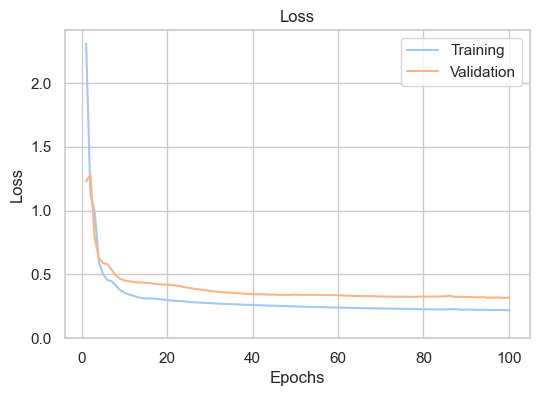

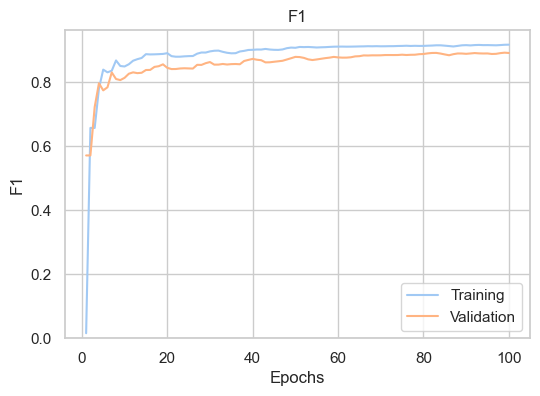

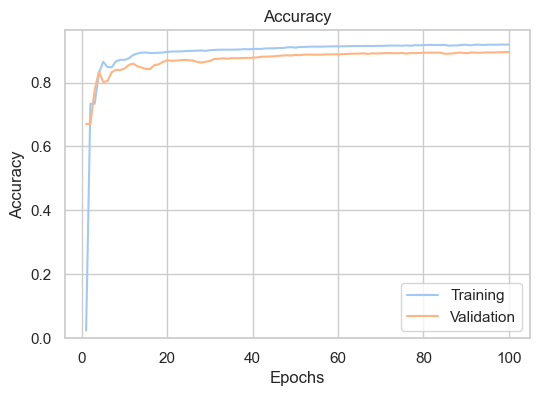

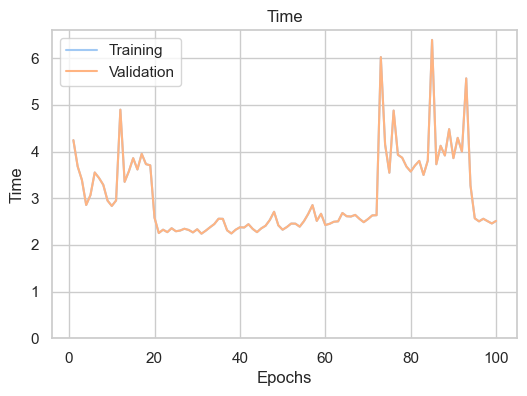

In [24]:
# All metrics are held within the model and can be called.
plot_metrics(model.train_loss, model.val_loss, 100, 'Loss')
plot_metrics(model.train_f1, model.val_f1, 100, 'F1')
plot_metrics(model.train_accuracy, model.val_accuracy, 100, 'Accuracy')
# There is only 1 time but omits errors if wanting to just plot 1.
plot_metrics(model.epoch_time, model.epoch_time, 100, 'Time')

# Predicted and actual labels. Add the labels to the original data and use it
# to filter certain rows. For example false positives.
y_pred1 = model.test_pred
actual1 = model.test_actual

In [25]:
# Seperate the data from the tensors and use the same train and test set for Random Forest.
tr_data, labels = train_data.tensors
tr_data = tr_data.squeeze()
tr_data = pd.DataFrame(tr_data)
tr_data['labels'] = pd.DataFrame(labels)
te_data, labels = test_data.tensors
te_data = te_data.squeeze()
te_data = pd.DataFrame(te_data)
te_data['labels'] = pd.DataFrame(labels)
X_train = tr_data.drop(columns='labels')
y_train = tr_data['labels']
X_test = te_data.drop(columns='labels')
y_test = te_data['labels']
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9400

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.02      0.04       354
           1       0.84      0.10      0.18       369
           2       0.39      0.27      0.32      2732
           3       0.65      0.86      0.74      7783
           4       0.76      0.89      0.82      4125
           5       1.00      0.99      0.99     41723
           6       1.00      0.98      0.99     47537
           7       0.92      0.78      0.85      2412
           8       0.64      0.60      0.61       272
           9       0.67      0.12      0.21        32

    accuracy                           0.94    107339
   macro avg       0.74      0.56      0.57    107339
weighted avg       0.94      0.94      0.94    107339



# SHAP Integration:

In [26]:
shap_data = test_data.tensors[0]
indices = torch.randperm(shap_data.size(0))[:1000]

shap_data = shap_data[indices]
shap_data.shape

X_test = X_test.iloc[indices.numpy()]
print(X_test.shape)
print(shap_data.shape)

(1000, 116)
torch.Size([1000, 1, 116])


In [27]:
shap_values = explainer.shap_values(shap_data)

In [28]:
x_tree = shap.TreeExplainer(rf_classifier)
shap_values_tree = x_tree.shap_values(X_test)

In [29]:
shap_data = shap_data.squeeze()
shap_values = shap_values.squeeze()
print(shap_data.shape)
print(shap_values.shape)

torch.Size([1000, 116])
(1000, 116, 10)


LSTM Model


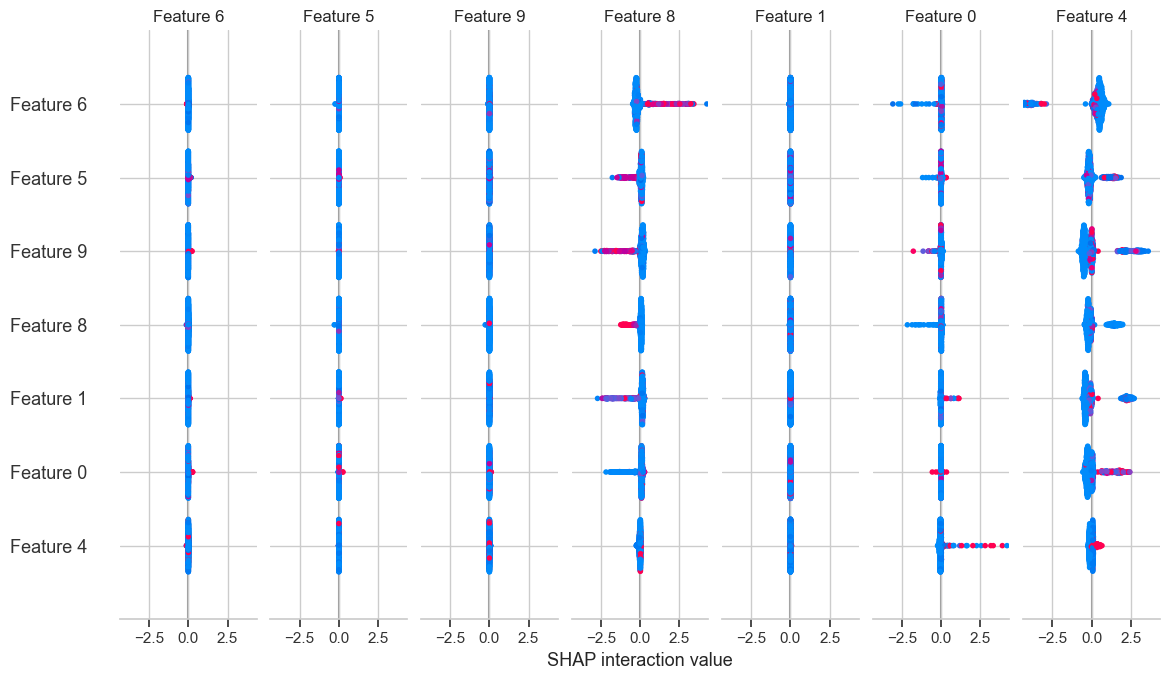

Random Forest


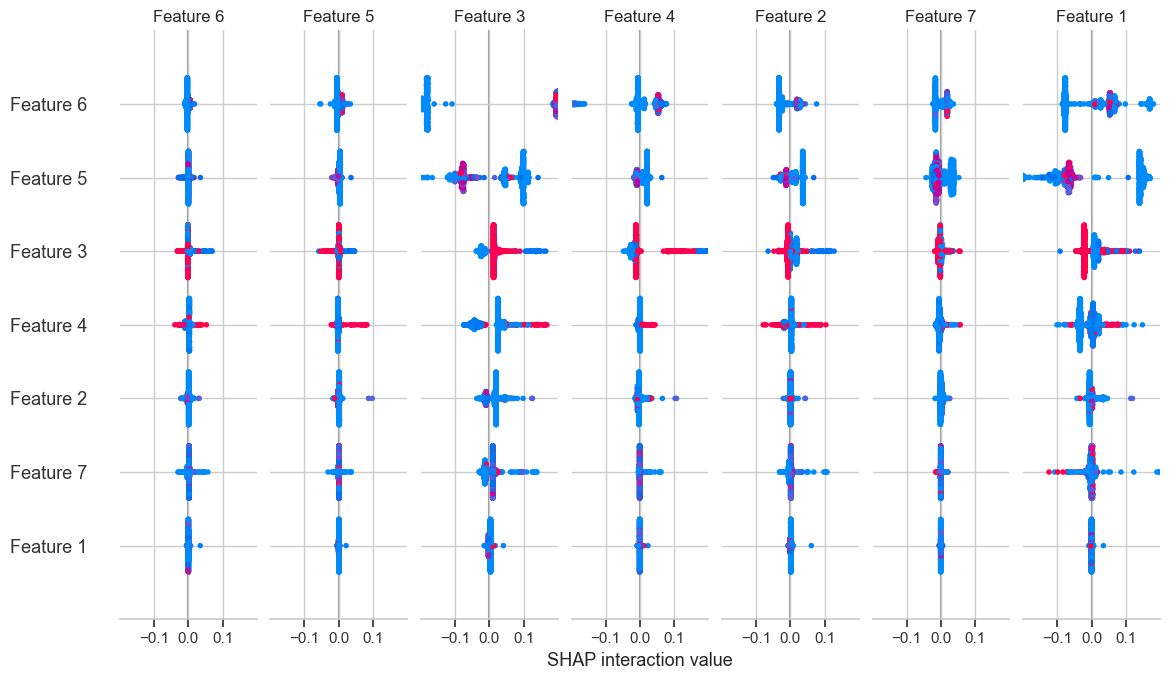

In [30]:
print('LSTM Model')
shap.summary_plot(shap_values, shap_data)
print('Random Forest')
shap.summary_plot(shap_values_tree, shap_data)

In [31]:
# Selecting label 6.
shap_values2 = shap_values[:, :, 6]
print(shap_values2.shape)
shap_values_tree2 = shap_values_tree[:, :, 6]
print(shap_values_tree2.shape)

(1000, 116)
(1000, 116)


LSTM Model


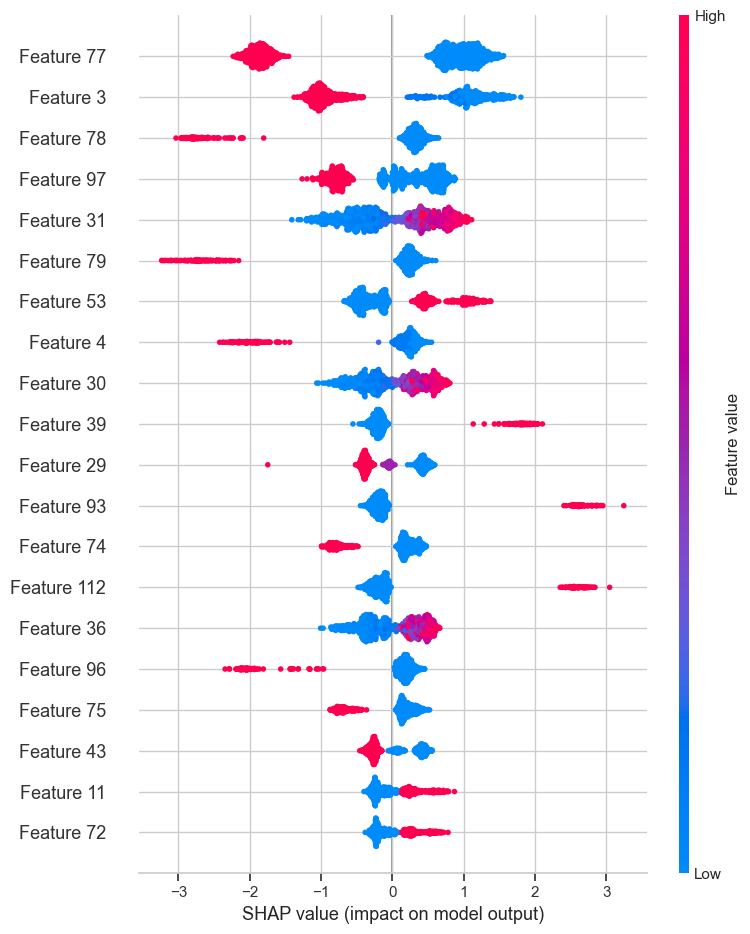

Random Forest


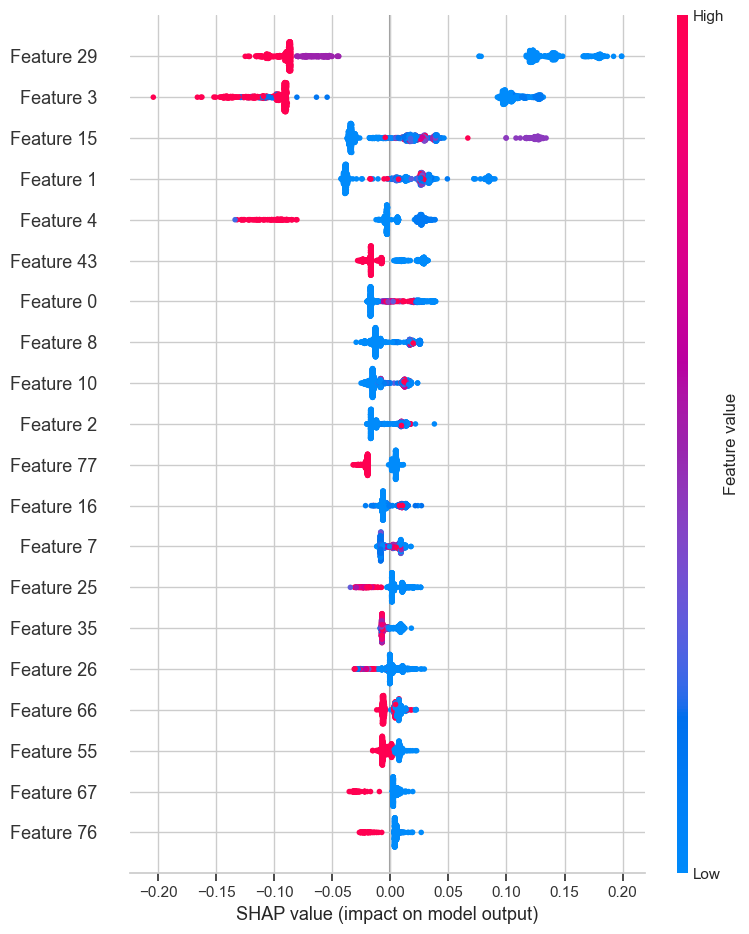

In [32]:
print('LSTM Model')
shap.summary_plot(shap_values2, shap_data)
print('Random Forest')
shap.summary_plot(shap_values_tree2, shap_data)

# Full Dataset Test:

In [48]:
ds = DataSamplerMulti()
train_data, val_data, test_data = ds.get_data('full_data', 0.15, 42, 0.1)
print(train_data.tensors[0].shape)
print(val_data.tensors[0].shape)
print(test_data.tensors[0].shape)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_19868\484315319.py:44: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_19868\484315319.py:49: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


torch.Size([1777819, 1, 108])
torch.Size([380960, 1, 108])
torch.Size([380960, 1, 108])


In [50]:
print(len(pd.DataFrame(train_data.tensors[1]).value_counts()))
print(len(pd.DataFrame(val_data.tensors[1]).value_counts()))
print(len(pd.DataFrame(test_data.tensors[1]).value_counts()))

10
10
1


In [ ]:
input_size = train_data.tensors[0].shape[2]
# Change hidden size for complexity.
hidden_size = 128
num_labels = len(np.unique(train_data.tensors[1]))
# Maybe try an additional layer?
num_layers = 1
# NOTE: Currently stuck with cpu as the shap_values calculation fails when mounted on GPU.
device = torch.device("cpu")
model = MultiLSTM(input_size, hidden_size, num_labels, num_layers, device, 'model')
criterion = nn.CrossEntropyLoss()
# Lower LR and increase epochs so we make sure not to miss the minimum.
# NOTE: The model continues to converge and could be optimised for more epochs to find the minimum
# then tuned with lr for time.
optimizer = optim.Adam(model.parameters(), lr=0.08)
explainer = model.run(train_data, val_data, test_data, criterion, optimizer, 100, 50)

In [35]:
# Seperate the data from the tensors and use the same train and test set for Random Forest.
#tr_data, labels = train_data.tensors
#tr_data = tr_data.squeeze()
#tr_data = pd.DataFrame(tr_data)
#tr_data['labels'] = pd.DataFrame(labels)
#te_data, labels = test_data.tensors
#te_data = te_data.squeeze()
#te_data = pd.DataFrame(te_data)
#te_data['labels'] = pd.DataFrame(labels)
#X_train = tr_data.drop(columns='labels')
#y_train = tr_data['labels']
#X_test = te_data.drop(columns='labels')
#y_test = te_data['labels']
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_classifier.fit(X_train, y_train)
#y_pred = rf_classifier.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy:.4f}')
#print("\nClassification Report:")
#print(classification_report(y_test, y_pred))